In [1]:
## batch generator
def generate_batch(df, size=32):
    tokens_list = []
    label_list = []
    for item in df:
        tokens_list.append(item[0])
        label_list.append(item[1])
    
        if len(tokens_list) == size:
            yield tokens_list, label_list
            tokens_list = []
            label_list = []
    if len(tokens_list) != 0:
        yield tokens_list, label_list

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from keras_preprocessing.sequence import pad_sequences

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from transformers import BertTokenizer, BertModel

# 创建一个空的 Tokenizer 对象
my_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
def prepare_sequences(sequences):
    ids = []
    attention_masks = []
    max_len = max([len(seq) for seq in sequences]) if max([len(seq) for seq in sequences])<248 else 248
    for seq in sequences:
        encoded = my_tokenizer.encode_plus(seq, add_special_tokens=True, max_length = max_len, padding='max_length',return_attention_mask=True, truncation=True, return_tensors='pt')
        ids.append(encoded["input_ids"][0])
        attention_masks.append(encoded["attention_mask"][0])
    return ids, attention_masks

In [6]:
import os
from transformers import BertTokenizer, BertModel
def load_vocab():
    file_path = os.path.join('aclImdb', 'imdb.vocab')
    f = open(file_path, 'r')
    lines = f.readlines()
    f.close()
    vocab = set()
    for line in lines:
        word = line.strip('\n')
        vocab.add(word)
    return vocab

vocab_set = load_vocab()
# vocab_set.add('<UNK>')
# vocab_set.add('<PAD>')

labels_dict = {'neg': 0, 'pos': 1}
characters=["<UNK>"]
my_tokenizer.add_tokens(characters)
bert.resize_token_embeddings(len(my_tokenizer))

def load_data_t(flag):
    file_path = os.path.join('aclImdb', flag)
    res = []
    sentences = []
    labels = []
    ids = []
    attention_masks = []
    max_len = 510
    for label in labels_dict.keys():
        for file_name in os.listdir(os.path.join(file_path, label)):
            with open(os.path.join(os.path.join(file_path, label), file_name), encoding='utf-8') as f:
                sentence = f.readline()
                sentence = sentence.lower()
                words_temp = sentence.split(' ')
                words = []
                for word in words_temp:
                    if word in vocab_set:
                        words.append(word)
                    else:
                        words.append('<UNK>')
                sentence = " ".join(words)
                # tokens = tokenize_and_cut(words)
                # input_ids = my_tokenizer.convert_tokens_to_ids(tokens)
                # if len(index) == len(words_index):
                # else:
                #     idxs = pad_sequences(maxlen=max_len, sequences=idxs, padding="post", value=-1)
                sentences.append(sentence)
                labels.append(labels_dict[label])
    return sentences, labels


In [7]:
train_sentences, train_labels = load_data_t('train')
test_sentences, test_labels = load_data_t('test')

In [43]:
import torch.nn as nn

class SentimentClassifier(nn.Module):
    def __init__(self, bert, hidden_size, num_classes, trained = True):
        super(SentimentClassifier, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.batchnorm = nn.BatchNorm1d(hidden_size)

    def forward(self, input_ids, attention_mask=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        pooled_output = output.pooler_output
        x = self.dropout(pooled_output)
        x = self.fc1(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.fc2(output[0])
        return pred_idx
#         n_correct += (torch.argmax(pred_idx, -1) == targets).sum().item()
#         n_total += len(outputs)

In [8]:
import torch.nn as nn


class BertSentimentModel(nn.Module):
    def __init__(self, bert_model):
        
        super(BertSentimentModel, self).__init__()
        self.bert = bert_model
        self.cls_layer = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask=None):

        # Feed input to BERT and obtain outputs.
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Obtain representations of [CLS] heads.
        cls_reps = outputs.last_hidden_state[:, 0]
        # Put these representations to classification layer to obtain logits.
        logits = self.cls_layer(cls_reps)
        return logits

In [9]:
class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        super().__init__()
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers=n_layers,
                          bidirectional=bidirectional,
                          batch_first=True,
                          dropout=0 if n_layers < 2 else dropout)
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, text, attention_mask):
        # text = [batch size, sent len]
        with torch.no_grad():
            embedded = self.bert(text, attention_mask = attention_mask)[0]
        # embedded = [batch size, sent len, emb dim]
        _, hidden = self.rnn(embedded)
        # hidden = [n layers * n directions, batch size, emb dim]
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        else:
            hidden = self.dropout(hidden[-1, :, :])
        # hidden = [batch size, hid dim]
        output = self.out(hidden)
        # output = [batch size, out dim]
        return output


In [11]:
import random
df_train_t = []
for i in range(len(train_sentences)):
    df_train_t.append((train_sentences[i], train_labels[i]))
random.shuffle(df_train_t)

In [12]:
df_test_t = []
for i in range(len(test_sentences)):
    df_test_t.append((test_sentences[i], test_labels[i]))

In [13]:
train_ids = []
train_attention_masks = []
train_label = []
bsz = 16
for i, (sentences, label) in enumerate(generate_batch(df_train_t, bsz)):
    sentences_in, amask = prepare_sequences(sentences)
    train_ids.append(sentences_in)
    train_attention_masks.append(amask)
    train_label.append(label)

In [14]:
test_ids = []
test_attention_masks = []
bsz = 16
for i, (sentences, label) in enumerate(generate_batch(df_test_t, bsz)):
    sentences_in, amask = prepare_sequences(sentences)
    test_ids.append(sentences_in)
    test_attention_masks.append(amask)

In [ ]:
train_ids[999][15]

In [66]:
train_label[999]

[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]

In [15]:
import pickle

with open('store/train_ids'+str(bsz), 'wb') as f:
    pickle.dump(train_ids, f, 0)
with open('store/train_sentences', 'wb') as f:
    pickle.dump(train_sentences, f, 0)
with open('store/train_labels', 'wb') as f:
    pickle.dump(train_labels, f, 0)
with open('store/train_attention_masks'+str(bsz), 'wb') as f:
    pickle.dump(train_attention_masks, f, 0)
    
with open('store/test_ids'+str(bsz), 'wb') as f:
    pickle.dump(test_ids, f, 0)
with open('store/test_sentences', 'wb') as f:
    pickle.dump(test_sentences, f, 0)
with open('store/test_labels', 'wb') as f:
    pickle.dump(test_labels, f, 0)
with open('store/test_attention_masks'+str(bsz), 'wb') as f:
    pickle.dump(test_attention_masks, f, 0)

In [10]:
import pickle

bsz = 16

with open('store/train_ids'+str(bsz), 'rb') as f:
    train_ids = pickle.load(f)
    
with open('store/train_sentences', 'rb') as f:
    train_sentences = pickle.load(f)
    
with open('store/train_labels', 'rb') as f:
    train_labels = pickle.load(f)
    
with open('store/train_attention_masks'+str(bsz), 'rb') as f:
    train_attention_masks = pickle.load(f)
    
with open('store/test_ids'+str(bsz), 'rb') as f:
    test_ids = pickle.load(f)

with open('store/test_sentences', 'rb') as f:
    test_sentences = pickle.load(f)
    
with open('store/test_labels', 'rb') as f:
    test_labels = pickle.load(f)
    
with open('store/test_attention_masks'+str(bsz), 'rb') as f:
    test_attention_masks = pickle.load(f)

In [18]:
model = BertSentimentModel(bert)
model = model.to(device)

[1,   200] train_loss: 0.27262 time: 251
[1,   399] train_loss: 0.29029 time: 253
[1,   598] train_loss: 0.27320 time: 254
[1,   797] train_loss: 0.25328 time: 254
[1,   996] train_loss: 0.27429 time: 254
[1,  1195] train_loss: 0.27142 time: 254
[1,  1394] train_loss: 0.24790 time: 254
[1,   200] val_loss: 0.39139 time: 84, accuracy: 0.938
[1,   399] val_loss: 0.23405 time: 85, accuracy: 0.875
[1,   598] val_loss: 0.13411 time: 85, accuracy: 1.000
[1,   797] val_loss: 0.18428 time: 85, accuracy: 0.938
[1,   996] val_loss: 0.33126 time: 86, accuracy: 0.938
[1,  1195] val_loss: 0.20275 time: 86, accuracy: 0.938
[1,  1394] val_loss: 0.07830 time: 88, accuracy: 1.000
epoch_train_loss: 0.269, epoch_val_loss: 0.222
[2,   200] train_loss: 0.13973 time: 255
[2,   399] train_loss: 0.13567 time: 254
[2,   598] train_loss: 0.11611 time: 253
[2,   797] train_loss: 0.11147 time: 254
[2,   996] train_loss: 0.12729 time: 253
[2,  1195] train_loss: 0.12719 time: 253
[2,  1394] train_loss: 0.10921 time

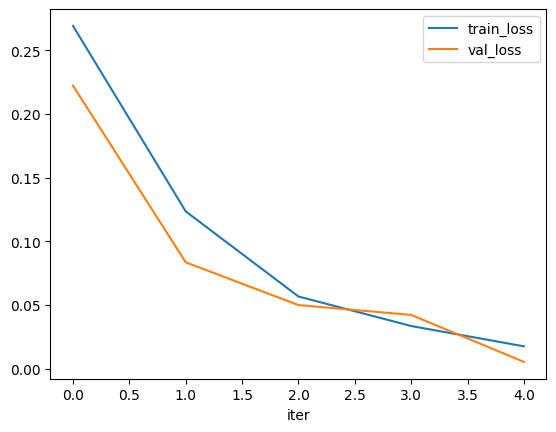

[6,   200] train_loss: 0.01753 time: 255
[6,   399] train_loss: 0.01845 time: 254
[6,   598] train_loss: 0.01528 time: 254
[6,   797] train_loss: 0.01490 time: 254
[6,   996] train_loss: 0.01047 time: 254
[6,  1195] train_loss: 0.01484 time: 254
[6,  1394] train_loss: 0.01020 time: 254
[6,   200] val_loss: 0.00062 time: 84, accuracy: 1.000
[6,   399] val_loss: 0.00174 time: 87, accuracy: 1.000
[6,   598] val_loss: 0.00040 time: 86, accuracy: 1.000
[6,   797] val_loss: 0.00050 time: 85, accuracy: 1.000
[6,   996] val_loss: 0.01655 time: 86, accuracy: 1.000
[6,  1195] val_loss: 0.00054 time: 85, accuracy: 1.000
[6,  1394] val_loss: 0.00034 time: 85, accuracy: 1.000
epoch_train_loss: 0.015, epoch_val_loss: 0.003
[7,   200] train_loss: 0.01018 time: 255
[7,   399] train_loss: 0.02481 time: 254
[7,   598] train_loss: 0.01372 time: 254
[7,   797] train_loss: 0.01702 time: 253
[7,   996] train_loss: 0.00708 time: 253
[7,  1195] train_loss: 0.01125 time: 253
[7,  1394] train_loss: 0.01080 time

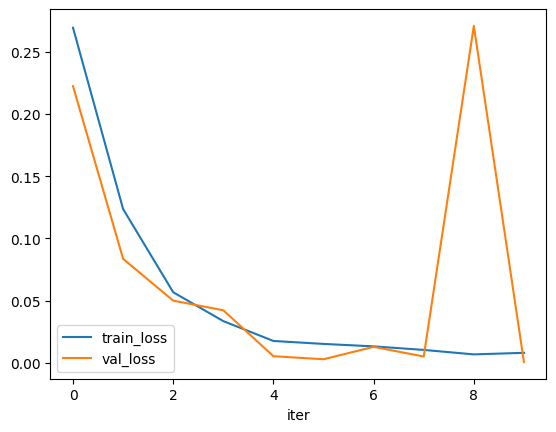

In [19]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

optimizer = optim.Adam(model.parameters(), lr=1e-5)

loss_function = nn.BCEWithLogitsLoss()
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(1,11):
    train_loss = []
    val_loss = []
    running_loss = 0.
    start_time = time.time()
    for i, (sentences, label) in enumerate(generate_batch(df_train_t, bsz)):
        optimizer.zero_grad()
   
        targets = torch.tensor(train_label[i]).to(device)
        sentences_in = train_ids[i]
        sentences_in = torch.tensor([s.tolist() for s in sentences_in]).to(device)
        attention_masks = train_attention_masks[i]
        amask = torch.tensor([t.tolist() for t in attention_masks]).to(device)
 
        y_pred = model(sentences_in, amask)
        loss = loss_function(y_pred.float().view(-1), targets.float())
        loss.requires_grad_(True)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        
        running_loss += loss.item()
        
        if i % 199 == 0 and i > 0: ## every 200 mini-batches
            ms_per_batch = (time.time() - start_time) * 1000 / 200
            print('[%d, %5d] train_loss: %.5f time: %d' % (epoch, i + 1, running_loss / 200, ms_per_batch))
            running_loss = 0.0
            start_time = time.time()
    
    with torch.no_grad():
        val_running_loss = 0  
        start_time = time.time()
        predictions=[]
        acc = 0
        for i, (sentences, label) in enumerate(generate_batch(df_train_t, bsz)):
            if i % 199 == 0 and i > 0: ## every 200 mini-batches
                targets = torch.tensor(train_label[i]).to(device)
                
                attention_masks = train_attention_masks[i]
                amask = torch.tensor([t.tolist() for t in attention_masks]).to(device)
                
                sentences_in = train_ids[i]
                sentences_in = torch.tensor([t.tolist() for t in sentences_in]).to(device)
                y_pred = model(sentences_in, amask)
                loss = loss_function(y_pred.float().view(-1), targets.float())
                
                y_preds = torch.round(torch.sigmoid(y_pred))
                
                for y in y_preds:
                    predictions.append(y.cpu().numpy()[0])
                
#                 for y in y_pred:
#                     if y.cpu().numpy()[0] > 0.5:
#                         predictions.append(1)
#                     else:
#                         predictions.append(0)
                        
                for j in range(len(predictions)):
                    if predictions[j] == label[j]:
                        acc += 1
                accuracy = acc/len(predictions)
                predictions=[]
                acc = 0

                val_loss.append(loss.item())
                val_running_loss +=loss.item()
                ms_per_batch = (time.time() - start_time) * 1000
                print('[%d, %5d] val_loss: %.5f time: %d, accuracy: %.3f' % (epoch, i+1, val_running_loss, ms_per_batch, accuracy))
                val_running_loss = 0.0
                start_time = time.time()
    print("==============================================")
    epoch_train_loss.append(np.mean(train_loss))
    epoch_val_loss.append(np.mean(val_loss)) 
    print("epoch_train_loss: %.3f, epoch_val_loss: %.3f" %(np.mean(train_loss), np.mean(val_loss)))
    print("==============================================")
    if epoch % 5 == 0:
            train_img = pd.DataFrame({"iter": range(len(epoch_train_loss)), "train_loss": epoch_train_loss})
            val_img = pd.DataFrame({"iter": range(len(epoch_val_loss)), "val_loss": epoch_val_loss})
            # gca stands for 'get current axis'
            ax = plt.gca()
            train_img.plot(kind='line', x='iter', y='train_loss', ax=ax)
            val_img.plot(kind='line', x='iter', y='val_loss', ax=ax)
            plt.show()

In [20]:
model.eval()
predictions = []

with torch.no_grad():
    for i, (sentences, label) in enumerate(generate_batch(df_test_t, bsz)):

        targets = torch.tensor(label, dtype=torch.float).to(device)
        attention_masks = test_attention_masks[i]
        amask = torch.tensor([t.tolist() for t in attention_masks]).to(device)

        sentences_in = test_ids[i]
        sentences_in = torch.tensor([t.tolist() for t in sentences_in]).to(device)
        y_pred = model(sentences_in, amask)
        y_preds = torch.round(torch.sigmoid(y_pred))

        for y in y_preds:
            predictions.append(y.cpu().numpy()[0])
#             if y.cpu().numpy()[0] > 0.5:
#                 predictions.append(1)
#             else:
#                 predictions.append(0)

acc = 0
for i in range(len(predictions)):
    if predictions[i] == test_labels[i]:
        acc += 1
print (acc/25000)

0.9002


In [21]:
import pickle

with open('store/prediction_result_bert', 'wb') as f:
    pickle.dump(predictions, f, 0)

with open('store/fine_tuned_bert', 'wb') as f:
    pickle.dump(model, f, 0)

The model has 112,242,177 trainable parameters
[1,   200] train_loss: 0.68709 time: 120
[1,   399] train_loss: 0.67844 time: 115
[1,   598] train_loss: 0.67835 time: 115
[1,   797] train_loss: 0.67972 time: 114
[1,   996] train_loss: 0.67973 time: 114
[1,  1195] train_loss: 0.68161 time: 114
[1,  1394] train_loss: 0.68067 time: 114
[1,   200] val_loss: 0.70059 time: 97, accuracy: 0.500
[1,   399] val_loss: 0.67507 time: 97, accuracy: 0.625
[1,   598] val_loss: 0.67194 time: 97, accuracy: 0.625
[1,   797] val_loss: 0.65729 time: 98, accuracy: 0.688
[1,   996] val_loss: 0.67880 time: 98, accuracy: 0.500
[1,  1195] val_loss: 0.70020 time: 100, accuracy: 0.438
[1,  1394] val_loss: 0.71040 time: 99, accuracy: 0.500
epoch_train_loss: 0.683, epoch_val_loss: 0.685
[2,   200] train_loss: 0.68431 time: 115
[2,   399] train_loss: 0.67873 time: 114
[2,   598] train_loss: 0.67948 time: 114
[2,   797] train_loss: 0.67880 time: 114
[2,   996] train_loss: 0.67863 time: 114
[2,  1195] train_loss: 0.680

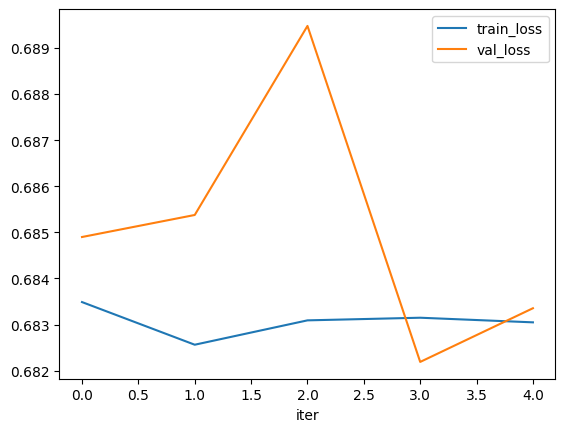

[6,   200] train_loss: 0.68546 time: 115
[6,   399] train_loss: 0.67880 time: 114
[6,   598] train_loss: 0.67858 time: 114
[6,   797] train_loss: 0.67826 time: 114
[6,   996] train_loss: 0.68062 time: 114
[6,  1195] train_loss: 0.68145 time: 114
[6,  1394] train_loss: 0.67850 time: 114
[6,   200] val_loss: 0.68092 time: 97, accuracy: 0.688
[6,   399] val_loss: 0.68634 time: 97, accuracy: 0.562
[6,   598] val_loss: 0.65937 time: 97, accuracy: 0.625
[6,   797] val_loss: 0.66691 time: 97, accuracy: 0.625
[6,   996] val_loss: 0.67144 time: 96, accuracy: 0.625
[6,  1195] val_loss: 0.71769 time: 96, accuracy: 0.438
[6,  1394] val_loss: 0.70509 time: 96, accuracy: 0.375
epoch_train_loss: 0.683, epoch_val_loss: 0.684
[7,   200] train_loss: 0.68677 time: 115
[7,   399] train_loss: 0.67865 time: 115
[7,   598] train_loss: 0.67910 time: 114
[7,   797] train_loss: 0.67916 time: 114
[7,   996] train_loss: 0.67898 time: 114
[7,  1195] train_loss: 0.68152 time: 114
[7,  1394] train_loss: 0.67968 time

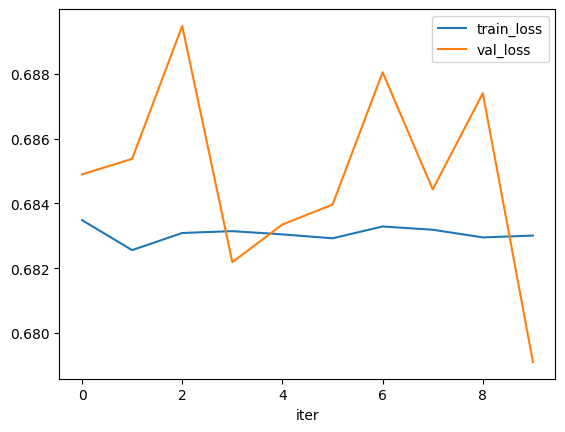

In [22]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25
model_bert_rnn = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

model_bert_rnn.to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model_bert_rnn):,} trainable parameters')
for name, param in model_bert_rnn.named_parameters():
    if name.startswith('bert'):
        param.requires_grad = False

import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

optimizer = optim.Adam(model.parameters(), lr=1e-5)

loss_function = nn.BCEWithLogitsLoss()
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(1,11):
    train_loss = []
    val_loss = []
    running_loss = 0.
    start_time = time.time()
    for i, (sentences, label) in enumerate(generate_batch(df_train_t, bsz)):
        optimizer.zero_grad()
        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        targets = torch.tensor(train_label[i]).to(device)
        sentences_in = train_ids[i]
        sentences_in = torch.tensor([s.tolist() for s in sentences_in]).to(device)
        attention_masks = train_attention_masks[i]
        amask = torch.tensor([t.tolist() for t in attention_masks]).to(device)
        # Step 3. Run our forward pass.
        y_pred = model_bert_rnn(sentences_in, amask)
        loss = loss_function(y_pred.float().view(-1), targets.float())
        loss.requires_grad_(True)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        
        running_loss += loss.item()
        
        if i % 199 == 0 and i > 0: ## every 200 mini-batches
            ms_per_batch = (time.time() - start_time) * 1000 / 200
            print('[%d, %5d] train_loss: %.5f time: %d' % (epoch, i + 1, running_loss / 200, ms_per_batch))
            running_loss = 0.0
            start_time = time.time()
    
    with torch.no_grad():
        val_running_loss = 0  
        start_time = time.time()
        predictions=[]
        acc = 0
        for i, (sentences, label) in enumerate(generate_batch(df_train_t, bsz)):
            if i % 199 == 0 and i > 0: ## every 200 mini-batches
                targets = torch.tensor(train_label[i]).to(device)
                
                attention_masks = train_attention_masks[i]
                amask = torch.tensor([t.tolist() for t in attention_masks]).to(device)
                
                sentences_in = train_ids[i]
                sentences_in = torch.tensor([t.tolist() for t in sentences_in]).to(device)
                y_pred = model_bert_rnn(sentences_in, amask)
                loss = loss_function(y_pred.float().view(-1), targets.float())
                
                y_preds = torch.round(torch.sigmoid(y_pred))
                
                for y in y_preds:
                    predictions.append(y.cpu().numpy()[0])
                
#                 for y in y_pred:
#                     if y.cpu().numpy()[0] > 0.5:
#                         predictions.append(1)
#                     else:
#                         predictions.append(0)
                        
                for j in range(len(predictions)):
                    if predictions[j] == label[j]:
                        acc += 1
                accuracy = acc/len(predictions)
                predictions=[]
                acc = 0

                val_loss.append(loss.item())
                val_running_loss +=loss.item()
                ms_per_batch = (time.time() - start_time) * 1000
                print('[%d, %5d] val_loss: %.5f time: %d, accuracy: %.3f' % (epoch, i+1, val_running_loss, ms_per_batch, accuracy))
                val_running_loss = 0.0
                start_time = time.time()
    print("==============================================")
    epoch_train_loss.append(np.mean(train_loss))
    epoch_val_loss.append(np.mean(val_loss)) 
    print("epoch_train_loss: %.3f, epoch_val_loss: %.3f" %(np.mean(train_loss), np.mean(val_loss)))
    print("==============================================")
    if epoch % 5 == 0:
            train_img = pd.DataFrame({"iter": range(len(epoch_train_loss)), "train_loss": epoch_train_loss})
            val_img = pd.DataFrame({"iter": range(len(epoch_val_loss)), "val_loss": epoch_val_loss})
            # gca stands for 'get current axis'
            ax = plt.gca()
            train_img.plot(kind='line', x='iter', y='train_loss', ax=ax)
            val_img.plot(kind='line', x='iter', y='val_loss', ax=ax)
            plt.show()


In [23]:
model_bert_rnn.eval()
predictions = []

with torch.no_grad():
    for i, (sentences, label) in enumerate(generate_batch(df_test_t, bsz)):

        targets = torch.tensor(label, dtype=torch.float).to(device)
        attention_masks = test_attention_masks[i]
        amask = torch.tensor([t.tolist() for t in attention_masks]).to(device)

        sentences_in = test_ids[i]
        sentences_in = torch.tensor([t.tolist() for t in sentences_in]).to(device)
        y_pred = model_bert_rnn(sentences_in, amask)
        y_preds = torch.round(torch.sigmoid(y_pred))

        for y in y_preds:
            predictions.append(y.cpu().numpy()[0])
#             if y.cpu().numpy()[0] > 0.5:
#                 predictions.append(1)
#             else:
#                 predictions.append(0)

acc = 0
for i in range(len(predictions)):
    if predictions[i] == test_labels[i]:
        acc += 1
print (acc/25000)

0.58848


In [24]:
with open('store/prediction_result_bertrnn', 'wb') as f:
    pickle.dump(predictions, f, 0)

with open('store/fine_tuned_bertrnn', 'wb') as f:
    pickle.dump(model_bert_rnn, f, 0)